In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import cv2
import random
from scipy.signal import savgol_filter
import sys
sys.path.append("src")
import sindy_utils as sindy
from datetime import datetime
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__() 
        self.encode = nn.Sequential(
            # encoder: N, 3, 404, 720
            nn.Conv2d(3, 16, 2), # N, 16, 403, 719
            nn.ReLU(),
            nn.Conv2d(16, 32, 2), # N, 32, 402, 718
            nn.ReLU(),
            nn.MaxPool2d((2,3), stride=(2,3)), # N, 32, 201, 239              -- pool --
            nn.Conv2d(32, 64, 4), # N, 64, 198, 236
            nn.ReLU(),
            nn.Conv2d(64, 96, 4), # N, 96, 195, 233
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # N, 96, 97, 116                       -- pool --
            nn.Conv2d(96, 128, 5), # N, 128, 93, 112
            nn.ReLU(),
            nn.Conv2d(128, 150, 5, stride=2, padding=1), # N, 150, 46, 55
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2), # N, 150, 23, 27                        -- pool --
            nn.Conv2d(150, 200, 9, stride=2), # N, 200, 8, 10
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(200*8*10,params['z_dim'])
        # Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
        # Input [-1, +1] -> use nn.Tanh    
        
        # note: encoder and decoder are not symmetric
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(200, 150, 4), # N, 150, 11, 13
            nn.ReLU(),
            nn.ConvTranspose2d(150, 128, 5, stride=(2,3), padding=(2,2), output_padding=(0,2)), # N, 128, 21, 39
            nn.ReLU(),
            nn.ConvTranspose2d(128, 96, 4, stride=2, padding=(1,0)), # N, 96, 42, 80
            nn.ReLU(),
            nn.ConvTranspose2d(96, 64, 8), # N, 64, 49, 87
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 8, stride=2, padding=(2,1), output_padding=(0,1)), # N, 32, 100, 179
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1), # N, 16, 201, 359
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 5, stride=2, padding=1, output_padding=(1,1)), # N, 3, 404, 720
            nn.ReLU()
        )   
        
        self.fc2 = nn.Linear(params['z_dim'], 200*8*10)

    def forward(self, x, z, mode):
        '''
        x: input for encoder
        z: input for decoder
        mode: 
            'train' -> use encoded for decoder
            'test'  -> feed z in an get decoded
        
        '''
        if mode == 'train':
            encoded = self.encode(x)
            encoded = encoded.view(-1,200*8*10)
            encoded = self.fc1(encoded)

            decoded = self.fc2(encoded)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        else:
            encoded = torch.zeros(1)

            decoded = self.fc2(z)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        
        return encoded, decoded

    
def calculateSindy(z, Xi, poly_order, include_sine_param):
    z_new = z.detach().numpy()
    
    theta = torch.from_numpy(sindy.sindy_library(z_new, poly_order, include_sine=include_sine_param))
    
    dz_prediction = torch.matmul(theta, Xi).float()
    
    return dz_prediction

def matrixToNorm(x, offset=0, factor=0.95):
    x = (x - x.min() + offset) / x.max() * factor
    return x

2022-01-10 12:01:24


### Data and model loading and configurations

In [9]:
############################## configurations #####################################
poly_order = 4
include_sine_param = False
threshold_sindy = 0.05
params = {}
params['z_dim'] = 3
params['lr_rate'] = 1e-5

# paths
path_folder = 'results/v5_hyperparam3_long/'
which_ae = 'Ae_1500epoch_bs16_lr1e-05_z3_sindt05_poly4.pt'
which_Xi = 'Xi_1500epoch_bs16_lr1e-05_z3_sindt05_poly4.pt'
saveFig = 'figures/v5_hyperparam3_long/'

In [11]:
to_load = path_folder + which_ae
autoencoder = torch.load(to_load)
autoencoder = autoencoder.cpu()

# load a train data
path_folder_data = path_folder+'data/'
train_data = torch.load(path_folder_data + 'train_data.pt')
print('train data: ', len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]), len(train_data[0][0][0][0]))
print('train data reading done!')

# load a validation data
validation_data = torch.load(path_folder_data + 'validation_data.pt')
print('validation data: ', len(validation_data), len(validation_data[0]), len(validation_data[0][0]), len(validation_data[0][0][0]), len(validation_data[0][0][0][0]))
print('validation data reading done!')

# loading test data
test_data = torch.load(path_folder_data + 'test_data.pt')
print('test data: ', len(test_data), len(test_data[0]), len(test_data[0][0]), len(test_data[0][0][0]), len(test_data[0][0][0][0]))
print('test data reading done!')

# load Xi
Xi = torch.load(path_folder + which_Xi)
print('Xi loaded succesfully!')
print(Xi)

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

### plotting images of autoencoder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

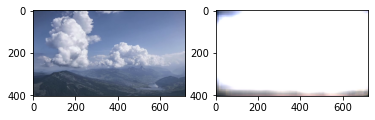

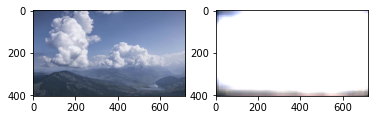

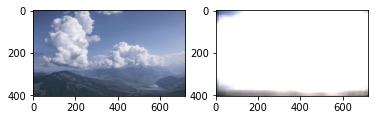

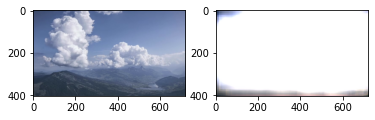

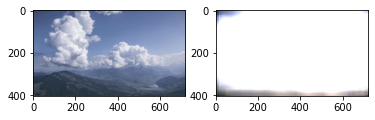

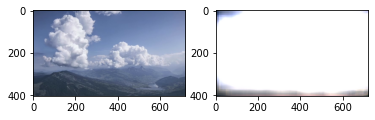

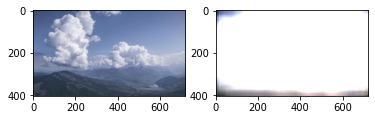

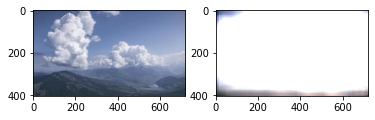

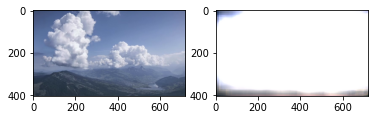

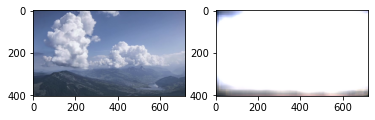

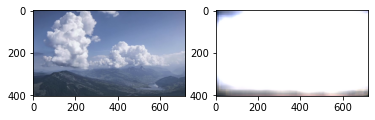

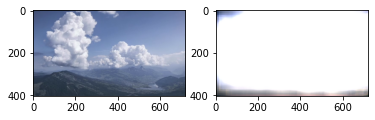

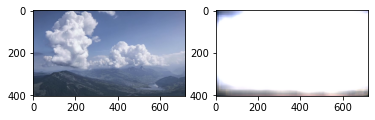

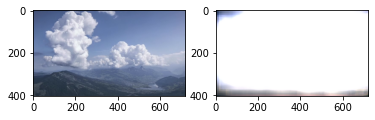

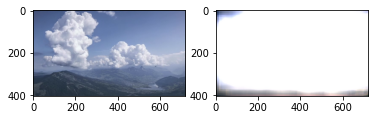

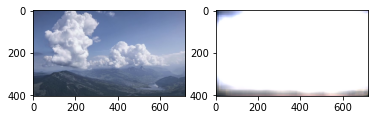

next random example


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

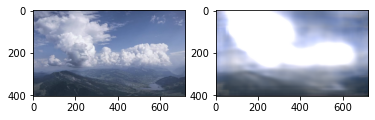

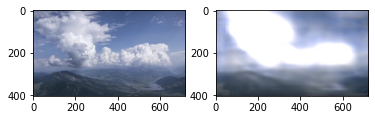

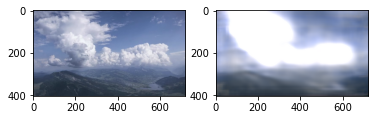

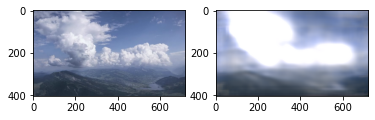

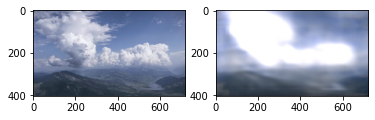

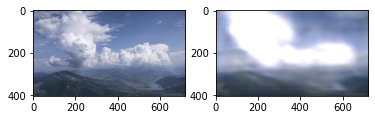

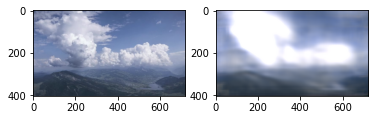

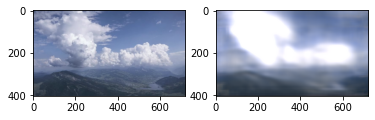

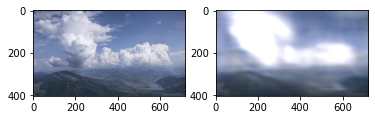

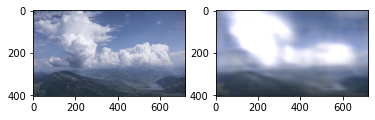

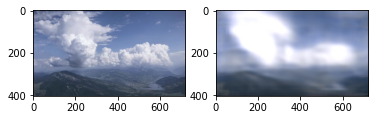

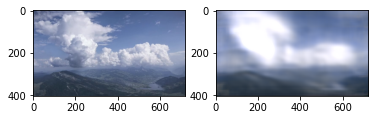

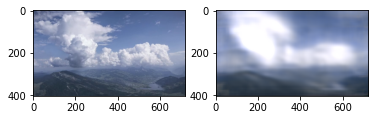

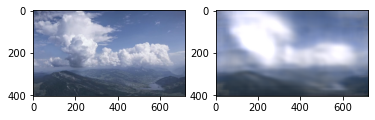

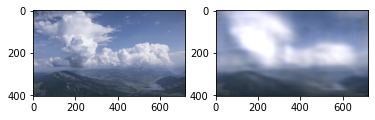

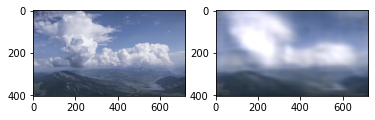

In [10]:
whichData = 1      # 1: train_data, 2: validation_data, 3: test_data
if whichData == 1:
    data = train_data
elif whichData == 2:
    data = validation_data
else:
    data = test_data

# plot autoencoder result
z_tensor, recon_tensor = autoencoder(data[0], 0, mode='train')
for nbImag in range(len(recon_tensor)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(data[0][nbImag].permute(1,2,0).detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(recon_tensor[nbImag].permute(1,2,0).detach().numpy())
    
# plot an other example from a random point in data
plt.show()
print('next random example')
randPlace = random.randint(0, len(data)-1)
z_tensor, recon_tensor = autoencoder(data[randPlace], 0, mode='train')
# plot sindy result
for nbImag in range(len(recon_tensor)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(data[randPlace][nbImag].permute(1,2,0).detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(recon_tensor[nbImag].permute(1,2,0).detach().numpy())
plt.savefig(saveFig + 'autoencoderResult_z'+str(params['z_dim'])'.png')
plt.show()


### plotting images for the first glance of prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Zero step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

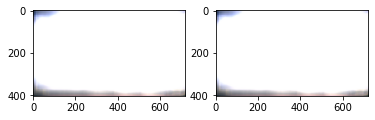

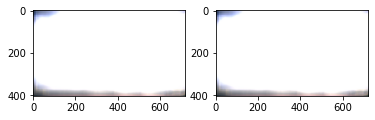

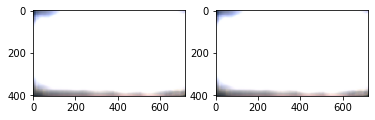

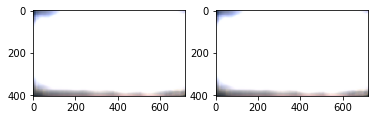

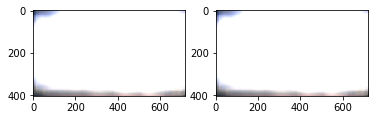

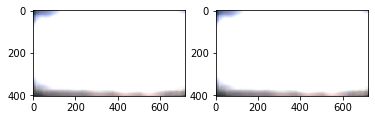

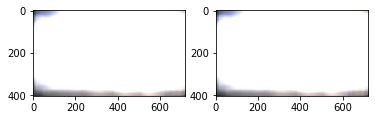

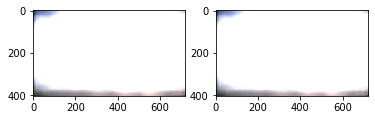

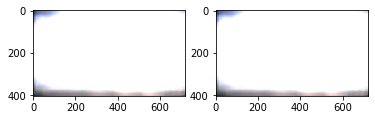

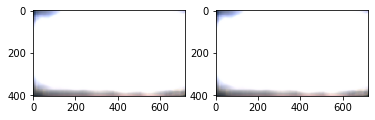

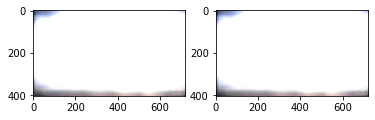

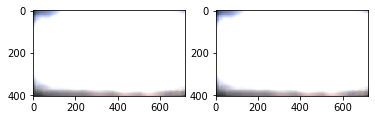

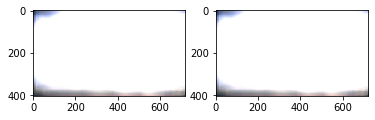

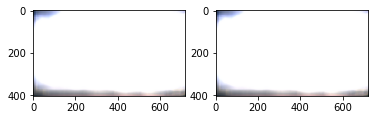

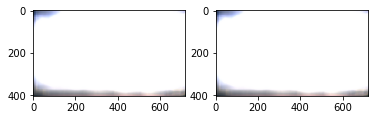

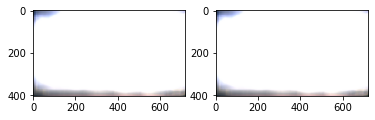

max recon_data 0.95
1. step
max of z_tensor -6.9603615
max of dz_tensor -6.999455
max of dz_predict -54716.203


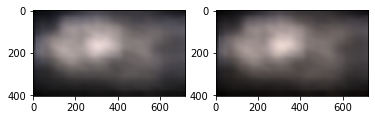

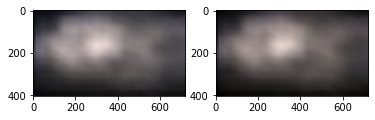

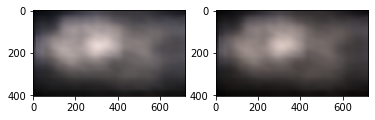

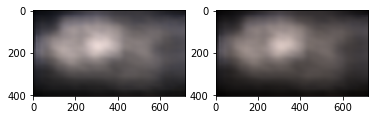

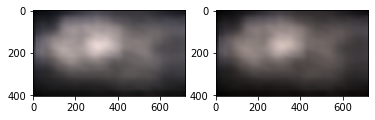

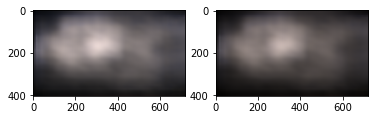

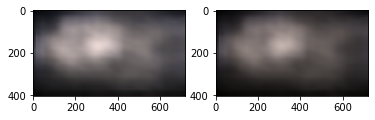

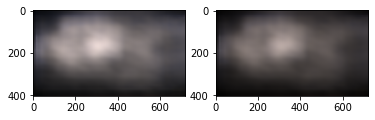

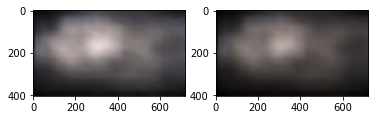

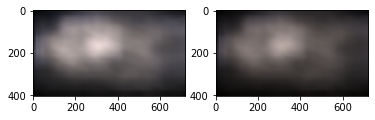

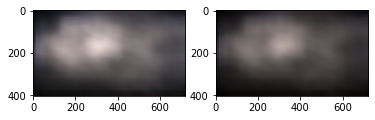

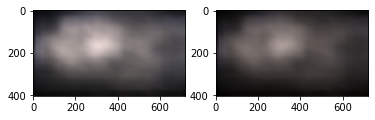

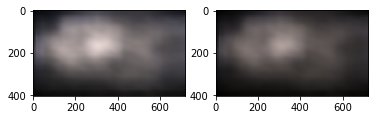

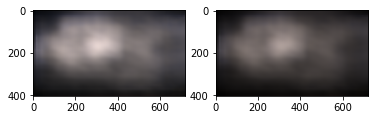

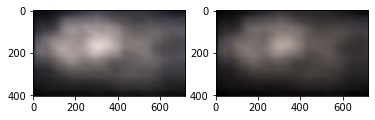

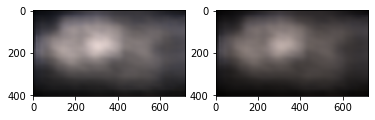

2. Step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

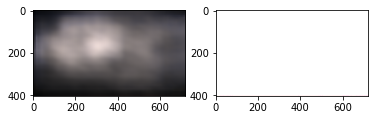

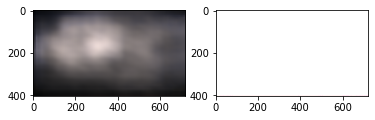

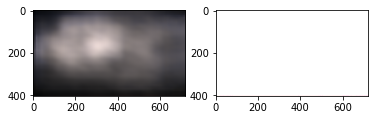

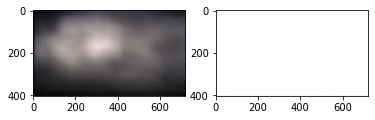

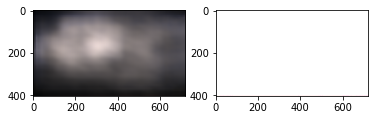

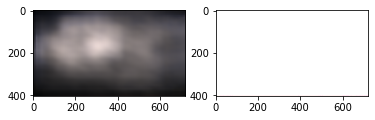

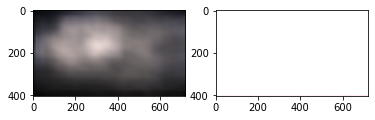

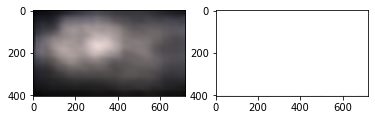

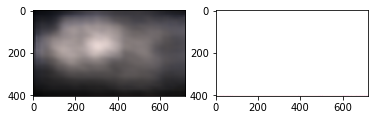

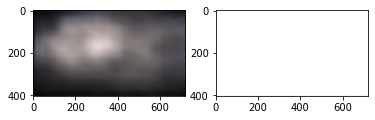

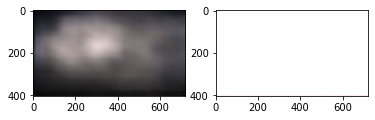

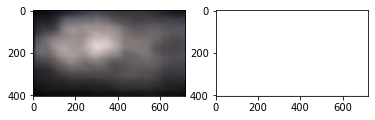

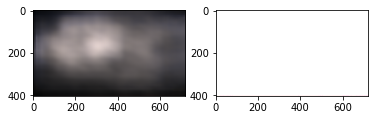

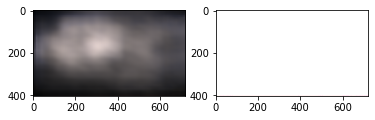

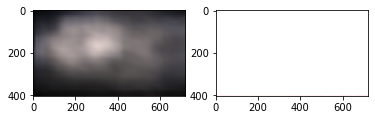

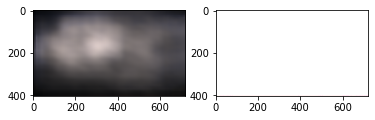

In [11]:
whichData = 1      # 1: train_data, 2: validation_data, 3: test_data
if whichData == 1:
    data = train_data
elif whichData == 2:
    data = validation_data
else:
    data = test_data
    
z_tensor, recon_tensor = autoencoder(data[0], 0, mode='train')

# plot zero step
print('Zero step')
for nbImag in range(len(recon_tensor)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon_tensor[nbImag].permute(1,2,0).detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(recon_tensor[nbImag].permute(1,2,0).detach().numpy())
plt.show()    
recon_tensor = matrixToNorm(recon_tensor)
print('max recon_data', recon_tensor.cpu().detach().numpy().max())


print('1. step')
dz_tensor, recon1_tensor = autoencoder(data[1], 0, mode='train')
z = z_tensor.cpu().detach().numpy()

Theta = torch.from_numpy(sindy.sindy_library(z, poly_order, include_sine=include_sine_param))
dz_predict = torch.matmul(Theta, Xi).float()
_, recon1_pred_tensor = autoencoder(0, dz_predict, mode='test')
print('max of z_tensor', z_tensor.cpu().detach().numpy().max())
print('max of dz_tensor', dz_tensor.cpu().detach().numpy().max())
print('max of dz_predict', dz_predict.cpu().detach().numpy().max())

recon1_tensor = matrixToNorm(recon1_tensor)
recon1_pred_tensor = matrixToNorm(recon1_pred_tensor)
# plot sindy result
for nbImag in range(len(recon1_tensor)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon1_tensor[nbImag].permute(1,2,0).detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(recon1_pred_tensor[nbImag].permute(1,2,0).detach().numpy())
plt.savefig(saveFig + 'prediction1StepResult_z'+str(params['z_dim'])'.png')
plt.show()

print('2. Step')
# new calculations
dz_tensor, recon2_tensor = autoencoder(data[2], 0, mode='train')

Theta2 = torch.from_numpy(sindy.sindy_library(dz_predict, poly_order, include_sine=include_sine_param))
dz_predict2 = torch.matmul(Theta2, Xi).float()
_, recon2_pred_tensor = autoencoder(0, dz_predict2, mode='test')

recon2_tensor = matrixToNorm(recon2_tensor)
#for i in range(len(recon2_pred_tensor)):
#    recon2_pred_tensor[i] = matrixToNorm(recon2_pred_tensor[i])
for nbImag in range(len(recon2_tensor)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon2_tensor[nbImag].permute(1,2,0).detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(recon2_pred_tensor[nbImag].permute(1,2,0).detach().numpy())
plt.savefig(saveFig + 'prediction2StepResult_z'+str(params['z_dim'])'.png')
plt.show()


### plotting in z dimension

0
5
z_true dimension (160, 1)
graph(s) for z_true


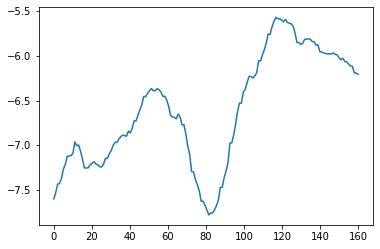

graph(s) for z_sindy prediction


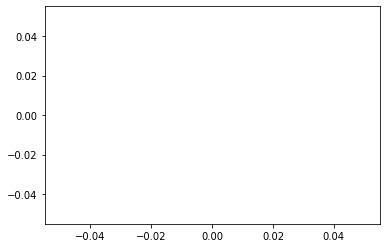

In [6]:
whichData = 1      # 1: train_data, 2: validation_data, 3: test_data
if whichData == 1:
    data = train_data
elif whichData == 2:
    data = validation_data
else:
    data = test_data
    
ChooseLength = 10  # len(data)
batch_size = 16

# compute true z
z_true = np.empty((ChooseLength*batch_size, params['z_dim']))
for index in range(0, ChooseLength):
    if index >= len(data):
        break
    z_tensor, recon_tensor = autoencoder(data[index], 0, mode='train')
    z_true[index*batch_size:(index+1)*batch_size][:] = z_tensor.cpu().detach().numpy()
    if index % 5 == 0: print(index)

print('z_true dimension', z_true.shape)
    
# print graph(s) for z_true
print('graph(s) for z_true')
for graph in range(z_true.shape[1]):
    plt.figure()
    x = np.linspace(0, z_true.shape[0], z_true.shape[0])
    y = z_true[:,graph]
    plt.plot(x, y)
    plt.savefig(saveFig + 'graph_z'+str(params['z_dim'])+'True_train' +str(graph)+ '.png')
plt.show()

# compute sindy z predition based on first one
z_tensor_first, recon_tensor_first = autoencoder(data[0], 0, mode='train')
z = z_tensor_first.cpu().detach().numpy()
z_sindy = np.empty((ChooseLength*batch_size, params['z_dim']))
z_sindy[0:16] = z
for index_s in range(0, ChooseLength-1):
    Theta = torch.from_numpy(sindy.sindy_library(z, poly_order, include_sine=include_sine_param))
    dz_predict = torch.matmul(Theta, Xi).float()
    z_sindy[(index_s+1)*batch_size:(index_s+2)*batch_size] = dz_predict.cpu().detach().numpy()
    z = dz_predict
    
    
# print graph(s) for z_sindy
print('graph(s) for z_sindy prediction')
for graph in range(z_sindy.shape[1]):
    plt.figure()
    x = np.linspace(0, z_sindy.shape[0], z_sindy.shape[0])
    z_sindy[:,graph] = savgol_filter(z_sindy[:,graph], 61, 3)
    y = z_sindy[:,graph]
    #y_smooth = savgol_filter(y, 61, 3) # window size 51, polynomial order 3
    plt.plot(x, y)
    #plt.plot(x, y_smooth, color='red')
    plt.savefig(saveFig + 'graph_z'+str(params['z_dim'])+'Sindy_train' +str(graph)+ '.png')


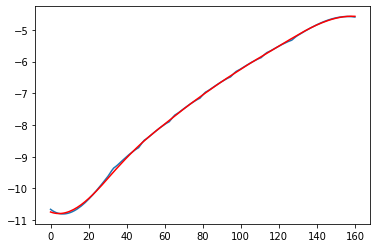

In [10]:
# test smoothing filter
x = np.linspace(0, z_sindy.shape[0], z_sindy.shape[0])
y = z_sindy[:,0]
y_smooth = savgol_filter(y, 61, 3) # window size 51, polynomial order 3
plt.plot(x, y)
plt.plot(x, y_smooth, color='red')

### Producing a video with sindy steps

In [ ]:
until = 10

# test model
def test(data):
    video_reconstruction = []
    # predict videos
    # first step encode first batch
    img = data[0]
    encode_tensor, recon_tensor = autoencoder(img, 0, mode='train')
    
    # predict the future using only sindy model, new video starts always at position vid_nbr * until
    for i in range(0, until):
        if i % 5 == 0: print('pred', i)
        video_reconstruction.append(recon_tensor)
        dz_tensor = calculateSindy(encode_tensor, Xi, poly_order, include_sine_param)
        _, recon_tensor = autoencoder(0, dz_tensor, mode='test')
        encode_tensor = dz_tensor
            
    return video_reconstruction


video_output = test(test_data)
print('prediction done!')

#del test_data

In [21]:
# test with z_sindy from above
batch_size = 16

# test model with filtered z coordinates
def test(zData):
    video_reconstruction = []
    # predict videos
    for i in range(int(len(zData)/batch_size)):
        print(i)
        z_tensor = torch.from_numpy(zData[i*batch_size:(i+1)*batch_size,:])
        _, recon_tensor = autoencoder(0, z_tensor.float(), mode='test')
        video_reconstruction.append(recon_tensor)        
            
    return video_reconstruction


video_output = test(z_sindy)
print('prediction done!')

#del test_data

0
1
2
3
4
5
6
7
8
9
prediction done!


In [24]:
# make videos
frame_width = len(video_output[0][0][0][0])
frame_height = len(video_output[0][0][0])
fps = 25.0
video_output = video_output
#fourcc = cv2.VideoWriter_fourcc('I','4','2','0')
#fourcc = cv2.VideoWriter_fourcc('P','I','M','1')
#fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
fourcc = cv2.VideoWriter_fourcc('D','I','V','3')
#fourcc = cv2.VideoWriter_fourcc('F','L','V','1')
# write different videos
#fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
#fourcc = cv2.VideoWriter_fourcc('D','I','V','3')
#fourcc = cv2.VideoWriter_fourcc('F','M','P','4')
out1 = cv2.VideoWriter(saveFig +'videoSindyPrediction.avi', fourcc, fps, (frame_width,frame_height))
#out2 = cv2.VideoWriter('video2.mov',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))


print('output video', len(video_output), len(video_output[0]), len(video_output[0][0]), len(video_output[0][0][0]), len(video_output[0][0][0][0]))

# undo batch structure
videoProcessing = []
count = -1
for img in range(0, len(video_output)*len(video_output[0])):
    imgIn_batch = img % batch_size
    # new batch
    if imgIn_batch == 0:
        count += 1
    img_toAppend = video_output[count][imgIn_batch]
    videoProcessing.append(img_toAppend)
        
#del video_output
print('video currently procession', len(videoProcessing), len(videoProcessing[0]), len(videoProcessing[0][0]), len(videoProcessing[0][0][0]))
    
for img in range(0,len(videoProcessing)):
    frame_local = np.transpose(videoProcessing[img].detach().numpy(), [1,2,0])
    frame_local = cv2.cvtColor(frame_local, cv2.COLOR_RGB2BGR)
    # print(frame_local) --> seems unstable, not a number and doesn't save it as a video
    out1.write(frame_local.shape)
    # show video
    cv2.imshow('Frame',frame_local)

    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q') and img >= 10:
        break
    
    # Press w on keyboard to wait
    if cv2.waitKey(25) & 0xFF == ord('w'):
        while(True):
            if cv2.waitKey(25) & 0xFF == ord('e'):
                break
            

# When everything done, release the video capture and video write objects
out1.release()

# Closes all the frames
cv2.destroyAllWindows()

print('finished prediction video output!')

output video 10 16 3 404 720
video currently procession 160 3 404 720
finished prediction video output!


### questions
- Do I have that Xi regresses to the next state, now it is kind of a loop?

In [ ]:
# use more than 16 frames to get Xi
def constructXi(data, zDim):
    '''
    input: data as a list with shape [len batch_size RGB hight width]
    return: Xi
    
    '''
    # processs the data
    z_tensor = torch.empty((0, zDim))
    data_len = len(data)
    for i in range(data_len):
        if i == 20:
            break
        z_tensor_tmp, _ = autoencoder(train_data[i], 0, mode='train')
        z_tensor = torch.cat((z_tensor, z_tensor_tmp), 0)
        if i % 5 == 0:
            print(i, z_tensor.shape)
        del z_tensor_tmp

    print(z_tensor.shape)
    
    dz_tensor = z_tensor[2:data_len]
    z_tensor = z_tensor[1:data_len-1]
    
    # calculate sindy and Xi for the data
    z = z_tensor.cpu().detach().numpy()
    dz = dz_tensor.cpu().detach().numpy()

    Theta = torch.from_numpy(sindy.sindy_library(z, poly_order, include_sine=include_sine_param))
    Xi = torch.from_numpy(sindy.sindy_fit(Theta, dz, threshold_sindy))
    
    return Xi

Xi = constructXi(train_data, zDim=2)

print(Xi)

print(z)
print(dz)
print(dz_predict)
print(dz_predict2)

print(recon2_pred_tensor[1].shape, len(recon2_pred_tensor))

In [ ]:
network = {}
network['Xi'] = Xi
params['poly_order'] = 4
params['sindy_threshold'] = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001, weight_decay=0)
pos = 0
z_tensor_tmp = torch.empty((0, params['z_dim'])).cpu()
for batch_id, img_tensor in enumerate(train_data):
    img_tensor = img_tensor.cpu()
    encode_tensor, recon_tensor = autoencoder(img_tensor, 0, mode='train')
    z_tensor_tmp = torch.cat((z_tensor_tmp, encode_tensor), 0)        # save all z-states for Xi calculation
    network['ae_loss'] = criterion(recon_tensor, img_tensor)

    # spacial case for first sindy epoch, we have no Xi yet
    if False:
        combined_loss = network['ae_loss']   
    # x, z is current batch_id, dx, dz is next one (in else we take dz as current and compare with x from before, the excite to current step)
    elif batch_id == 0:
        pos += 1
        combined_loss = network['ae_loss']       
        network['z'] = encode_tensor#.float()  
    else:
        network['dx'] = img_tensor#.float()
        network['dz'] = encode_tensor#.float()
        Theta = torch.from_numpy(sindy.sindy_library(network['z'].cpu().detach().numpy(), params['poly_order'], include_sine=False))
        network['dz_sindy'] = torch.matmul(Theta, network['Xi']).float().cpu()
        _, network['dx_sindy'] = autoencoder(0, network['dz_sindy'], mode='test')
        #combined_loss = networkLoss()            # total loss with SINDy
        # now advance one step
        network['z'] = network['dz']
                    
    # optimization and backpropagation
    #optimizer.zero_grad()
    #combined_loss.backward()
    #optimizer.step()

    # tensorboard
    #writer.add_scalar(f'Training loss / batch; ae: {nbrAeEpoch}epochs / sindy: {nbrSindyEpoch}epochs', combined_loss, global_step=steps)
    #writer.add_histogram('fc1', autoencoder.fc1.weight, global_step=steps)
    #steps += 1

    # printProgress(epoch, batch_id, combined_loss)
    img_tensor = img_tensor.detach()
        
# calculate Xi for the hole batch
print(z_tensor_tmp.shape)
dz_tensor_tmp = z_tensor_tmp[16:len(z_tensor_tmp)].cpu().detach().numpy()
z_tensor_tmp = z_tensor_tmp[0:len(z_tensor_tmp)-16].cpu().detach().numpy()

print(z_tensor_tmp.shape)
print(dz_tensor_tmp.shape)
        
Theta = torch.from_numpy(sindy.sindy_library(z_tensor_tmp, params['poly_order'], include_sine=False))
network['Xi'] = torch.from_numpy(sindy.sindy_fit(Theta, dz_tensor_tmp, params['sindy_threshold']))
z_tensor_tmp = torch.empty((0, params['z_dim'])).cpu()
dz_tensor_tmp = torch.empty((0, params['z_dim'])).cpu()
del z_tensor_tmp
del dz_tensor_tmp

In [ ]:
print(z_tensor_tmp.shape)
print(len(z_tensor_tmp), z_tensor_tmp.shape[0])

#dz_tensor_tmp = z_tensor_tmp[16:len(z_tensor_tmp)].cpu().detach().numpy()
#z_tensor_tmp = z_tensor_tmp[0:len(z_tensor_tmp)-16].cpu().detach().numpy()

print(z_tensor_tmp.shape)
print(dz_tensor_tmp.shape)

# print graph(s) for z_true
print('graph(s)')
for graph in range(z_tensor_tmp.shape[1]):
    plt.figure()
    x = np.linspace(0, 160, 160)
    y = z_tensor_tmp[0:160,graph]
    plt.plot(x, y)
plt.show()

print('graph(s) dz')
for graph in range(dz_tensor_tmp.shape[1]):
    plt.figure()
    x = np.linspace(0, 160, 160)
    y = dz_tensor_tmp[0:160,graph]
    plt.plot(x, y)
plt.show()

ThetaTest = torch.from_numpy(sindy.sindy_library(z_tensor_tmp, params['poly_order'], include_sine=False))
XiTest = torch.from_numpy(sindy.sindy_fit(ThetaTest, dz_tensor_tmp, params['sindy_threshold']))
z = z_tensor_tmp[0:16]
z_sindyTest = np.empty((160,2))
for index_s in range(0, 10):
    z_sindyTest[(index_s)*batch_size:(index_s+1)*batch_size] = z
    ThetaTest = torch.from_numpy(sindy.sindy_library(z, params['poly_order'], include_sine=False))
    dz_predictTest = torch.matmul(ThetaTest, XiTest).float()
    z = dz_predictTest.cpu().detach().numpy()

print('graph(s) dz predication')
for graph in range(z_sindyTest.shape[1]):
    plt.figure()
    x = np.linspace(0, z_sindyTest.shape[0], z_sindyTest.shape[0])
    y = z_sindyTest[:,graph]
    plt.plot(x, y)
plt.show()